In [27]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, RandomTreesEmbedding
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
import seaborn as sns
from imblearn.pipeline import Pipeline
import shap
from sklearn.inspection import permutation_importance
from xgboost import plot_importance
import pickle
import seaborn as sns
sns.set(style="white")

# For reproducibility
np.random.seed(42)

In [28]:
X_train = np.load('X_train_PE_no_lab_measurement_SpainUK.npy')
X_test = np.load('X_test_PE_no_lab_measurement_SpainUK.npy')
y_train = np.load('y_train_PE_no_lab_measurement_SpainUK.npy')
y_test = np.load('y_test_PE_no_lab_measurement_SpainUK.npy')

In [29]:
# Scale age
pre = preprocessing.StandardScaler()

age_column = X_train[:, 0]
age_column = np.atleast_2d(age_column).T

X_train[:, 0] = pre.fit_transform(age_column).ravel()

age_column = X_test[:, 0]
age_column = np.atleast_2d(age_column).T

X_test[:, 0] = pre.transform(age_column).ravel()

In [30]:
# Get the validation folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

# XGBoost

In [11]:
# Tune the XGBoost model using Bayesian optimisation
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for XGBoost hyperparameters
# Depth of tree
max_depth = np.linspace(1, 12, 12, endpoint=True)
max_depth = [round(x) for x in max_depth]
# maximum features
n_estimators = list(range(50, 400, 50))
# Learning rate
lr = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7]
# Regularisation for imbalanced data
max_delta_step = [0, 1, 3, 5, 7, 10]

# Create the grid
param_grid = {'max_depth': max_depth,
               'n_estimators': n_estimators,
               'learning_rate': lr,
               'max_delta_step': max_delta_step}

In [12]:
# Define the model you are interested in
XGBOOSTmodel = XGBClassifier(use_label_encoder=False)

In [13]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(XGBOOSTmodel, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[10:42:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[10:51:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:51:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:51:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[10:58:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:58:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:59:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:03:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:03:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:03:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:10:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:10:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:10:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:22:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:22:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:22:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:28:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:28:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:34:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:34:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:35:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:42:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:42:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:43:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:48:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      enable_categorical=False, gamma=None,
                                      gpu_id=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_delta_step=None,
                                      max_depth=None, min_...
                                      reg_lambda=None, scale_pos_weight=None,
                                      subsample=None, tree_method=None,
                                      use_label_encoder=False,
                                      validate_parameters=None,
                                   

In [14]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('learning_rate', 0.1), ('max_delta_step', 3), ('max_depth', 3), ('n_estimators', 250)])
Best AUROC: 0.7419329256511911


Best parameter combo: OrderedDict([('learning_rate', 0.1), ('max_delta_step', 3), ('max_depth', 3), ('n_estimators', 250)])
Best AUROC: 0.7419329256511911

In [5]:
# Test the model on standalone set
XGBOOSTmodel = XGBClassifier(max_depth = 3, n_estimators = 250,learning_rate = 0.1, max_delta_step = 3, use_label_encoder=False)

In [6]:
XGBOOSTmodel.fit(X_train, np.ravel(y_train))

[09:48:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=3,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [17]:
print('AUROC is:', metrics.roc_auc_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, XGBOOSTmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))

AUROC is: 0.7369240187525914
Accuracy is: 0.9829234338747099
Average Precision is: 0.04916719491405175


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


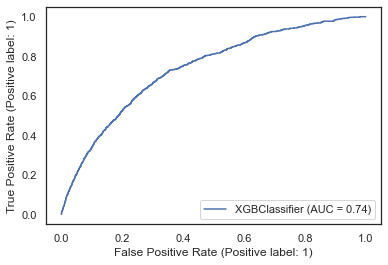

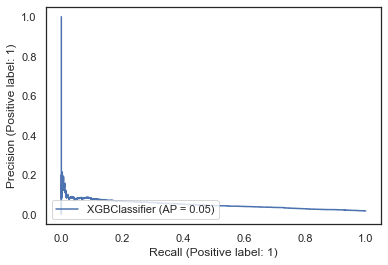

In [18]:
# Make metric plots
metrics.plot_roc_curve(XGBOOSTmodel, X_test, y_test) 
metrics.plot_precision_recall_curve(XGBOOSTmodel, X_test, y_test) 
plt.show()

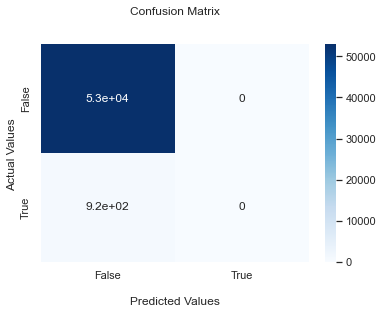

In [19]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, XGBOOSTmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [97]:
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = XGBOOSTmodel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.017, AUROC-Score=0.69945


In [107]:
y_pred = (XGBOOSTmodel.predict_proba(X_test)[:,1] >= 0.017).astype(int) # set threshold as 0.3

print('AUROC is:', metrics.roc_auc_score(y_test, y_pred))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred))

AUROC is: 0.6848948861420484
Accuracy is: 0.6577076566125291
Average Precision is: 0.029737301085578448


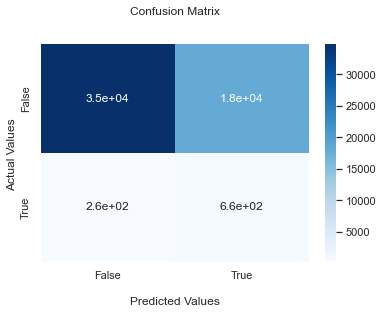

In [100]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [108]:
# Sensitivity is recall of positive class
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.66      0.79     52955
           1       0.03      0.71      0.07       920

    accuracy                           0.66     53875
   macro avg       0.51      0.68      0.43     53875
weighted avg       0.98      0.66      0.78     53875



In [7]:
# Feature Importance
explainer = shap.TreeExplainer(XGBOOSTmodel)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


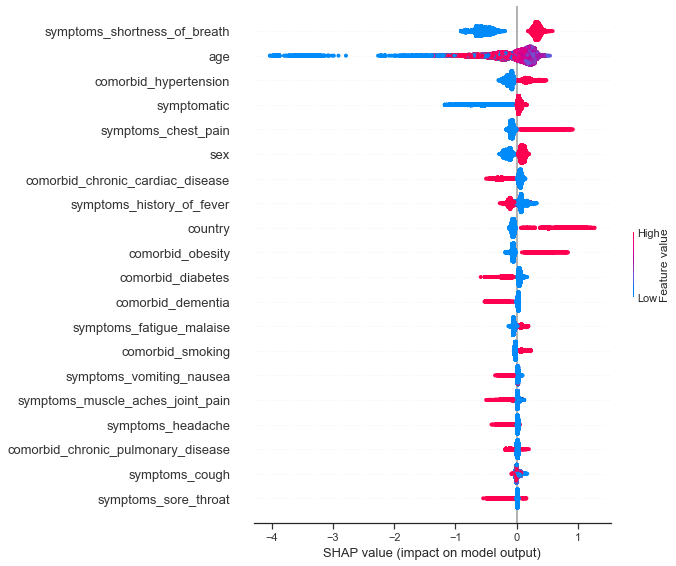

In [8]:
features = ['age', 'sex', 'country', 'comorbid_aids_hiv', 'comorbid_asthma',
       'comorbid_chronic_cardiac_disease',
       'comorbid_chronic_haematological_disease',
       'comorbid_chronic_kidney_disease',
       'comorbid_chronic_neurological_disorder',
       'comorbid_chronic_pulmonary_disease', 'comorbid_dementia',
       'comorbid_diabetes', 'comorbid_hypertension',
       'comorbid_immunosuppression', 'comorbid_liver_disease',
       'comorbid_malignant_neoplasm', 'comorbid_malnutrition',
       'comorbid_obesity', 'comorbid_rheumatologic_disorder',
       'comorbid_smoking', 'comorbid_tuberculosis', 'symptomatic',
       'symptoms_abdominal_pain', 'symptoms_altered_consciousness_confusion',
       'symptoms_bleeding', 'symptoms_chest_pain', 'symptoms_conjunctivitis',
       'symptoms_cough', 'symptoms_diarrhoea', 'symptoms_ear_pain',
       'symptoms_fatigue_malaise', 'symptoms_headache',
       'symptoms_history_of_fever', 'symptoms_lost_altered_sense_of_smell',
       'symptoms_lost_altered_sense_of_taste', 'symptoms_lymphadenopathy',
       'symptoms_muscle_aches_joint_pain', 'symptoms_runny_nose',
       'symptoms_seizures', 'symptoms_severe_dehydration',
       'symptoms_shortness_of_breath', 'symptoms_skin_rash',
       'symptoms_sore_throat', 'symptoms_vomiting_nausea', 'symptoms_wheezing']
shap.summary_plot(shap_values, X_test, feature_names=features)

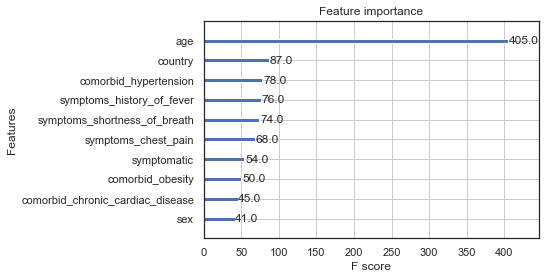

In [11]:
XGBOOSTmodel.get_booster().feature_names = features
plot_importance(XGBOOSTmodel.get_booster(), max_num_features=10)
plt.show()

In [ ]:
%%time


# Random Forest

In [20]:
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for RF hyperparameters
# Number of trees in random forest
n_estimators = [10, 25, 50, 100, 150]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 50]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [21]:
# Define the model you are interested in
RFmodel = RandomForestClassifier()

In [22]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(RFmodel, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=RandomForestClassifier(), refit=False,
              scoring='roc_auc',
              search_spaces={'bootstrap': [True, False],
                             'max_depth': [10, 50, None],
                             'max_features': ['auto', 'sqrt'],
                             'min_samples_leaf': [2, 4, 10],
                             'min_samples_split': [5, 10],
                             'n_estimators': [10, 25, 50, 100, 150]},
              verbose=1)

In [23]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('bootstrap', False), ('max_depth', 10), ('max_features', 'auto'), ('min_samples_leaf', 4), ('min_samples_split', 5), ('n_estimators', 150)])
Best AUROC: 0.7410700502798647


Best parameter combo: OrderedDict([('bootstrap', False), ('max_depth', 10), ('max_features', 'auto'), ('min_samples_leaf', 4), ('min_samples_split', 5), ('n_estimators', 150)])
Best AUROC: 0.7410700502798647

In [24]:
# Test the model on standalone set
RFmodel = RandomForestClassifier(n_estimators = 150, max_features = 'auto', max_depth = 10, min_samples_split = 5, min_samples_leaf = 4, bootstrap = False)

In [25]:
RFmodel.fit(X_train, np.ravel(y_train))

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=4,
                       min_samples_split=5, n_estimators=150)

In [26]:
print('AUROC is:', metrics.roc_auc_score(y_test, RFmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, RFmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, RFmodel.predict_proba(X_test)[:,1]))

AUROC is: 0.7389828935971067
Accuracy is: 0.9829234338747099
Average Precision is: 0.0510964641624084


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


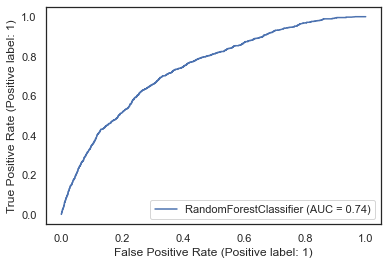

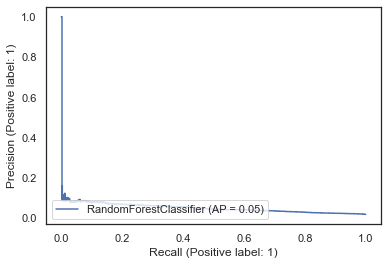

In [27]:
# Make metric plots
metrics.plot_roc_curve(RFmodel, X_test, y_test) 
metrics.plot_precision_recall_curve(RFmodel, X_test, y_test) 
plt.show()

# Logistic Regression

In [28]:
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for ElasticNet hyperparameters
# Regularisation constant
classifier__C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
# Which norm to use for regularisation
classifier__penalty = ['l1', 'l2']

# Create the grid
param_grid = {'C': classifier__C,
               'penalty': classifier__penalty}

In [29]:
# Define the model you are interested in
LOGmodel = LogisticRegression(solver='liblinear', class_weight = 'balanced')

In [30]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(LOGmodel, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=LogisticRegression(class_weight='balanced',
                                           solver='liblinear'),
              refit=False, scoring='roc_auc',
              search_spaces={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                             'penalty': ['l1', 'l2']},
              verbose=1)

In [31]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('C', 0.1), ('penalty', 'l1')])
Best AUROC: 0.7232966387336559


Best parameter combo: OrderedDict([('C', 0.1), ('penalty', 'l1')])


In [32]:
# Test the model on standalone set
LOGmodel = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', class_weight = 'balanced')

In [33]:
LOGmodel.fit(X_train, np.ravel(y_train))

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [34]:
print('AUROC is:', metrics.roc_auc_score(y_test, LOGmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, LOGmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, LOGmodel.predict_proba(X_test)[:,1]))

AUROC is: 0.7165881203482859
Accuracy is: 0.6410208816705336
Average Precision is: 0.04222280796068017


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


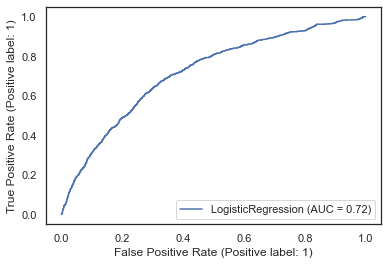

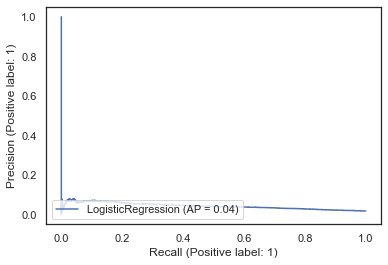

In [35]:
# Make metric plots
metrics.plot_roc_curve(LOGmodel, X_test, y_test) 
metrics.plot_precision_recall_curve(LOGmodel, X_test, y_test) 
plt.show()

# XGBoost with resampling

In [31]:
# Resample on the training set
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
X_res, y_res = under.fit_resample(X_train, y_train)

In [39]:
# Define the model you are interested in
XGBOOSTmodel = XGBClassifier(use_label_encoder=False)

In [40]:
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('sampling', under), ('model', XGBOOSTmodel)]
model = Pipeline([
        ('sampling', under),
        ('classification', XGBOOSTmodel)
    ])

In [41]:
# Tune the XGBoost model using Bayesian optimisation
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for XGBoost hyperparameters
# Depth of tree
max_depth = np.linspace(1, 12, 12, endpoint=True)
max_depth = [round(x) for x in max_depth]
# maximum features
n_estimators = list(range(50, 400, 50))
# Learning rate
lr = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7]
# Regularisation for imbalanced data
max_delta_step = [0, 1, 3, 5, 7, 10]

# Create the grid
param_grid = {'classification__max_depth': max_depth,
               'classification__n_estimators': n_estimators,
               'classification__learning_rate': lr,
               'classification__max_delta_step': max_delta_step}

In [42]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(model, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:33:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:33:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:33:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:34:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:34:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:35:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:35:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:35:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:36:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:37:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:37:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:37:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:38:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:38:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:38:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:39:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:39:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:39:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:40:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:42:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:42:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:42:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=Pipeline(steps=[('sampling',
                                         RandomUnderSampler(random_state=42,
                                                            sampling_strategy=0.25)),
                                        ('classification',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       enable_categorical=False,
                                                       gamma=None, gpu_id=None,
                                                       im...
                                                  

In [43]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('classification__learning_rate', 0.1), ('classification__max_delta_step', 5), ('classification__max_depth', 3), ('classification__n_estimators', 200)])
Best AUROC: 0.7401521961091377


Best parameter combo: OrderedDict([('classification__learning_rate', 0.1), ('classification__max_delta_step', 5), ('classification__max_depth', 3), ('classification__n_estimators', 200)])

In [32]:
# Test the model on standalone set
XGBOOSTmodel = XGBClassifier(max_depth = 3, n_estimators = 200,learning_rate = 0.1, max_delta_step = 5, use_label_encoder=False)

In [33]:
XGBOOSTmodel.fit(X_res, np.ravel(y_res))

[11:55:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=5,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [47]:
print('AUROC is:', metrics.roc_auc_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, XGBOOSTmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))

AUROC is: 0.7396797937543361
Accuracy is: 0.9612621809744779
Average Precision is: 0.04797442023352581


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


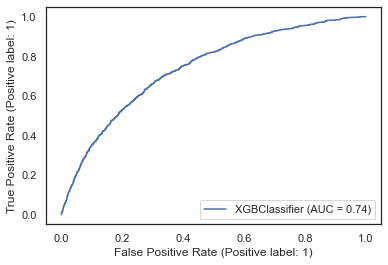

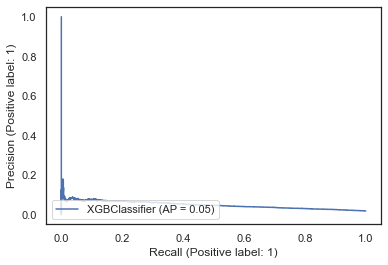

In [48]:
# Make metric plots
metrics.plot_roc_curve(XGBOOSTmodel, X_test, y_test) 
metrics.plot_precision_recall_curve(XGBOOSTmodel, X_test, y_test) 
plt.show()

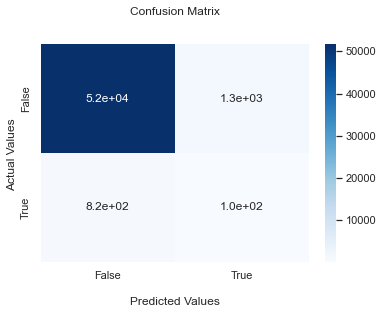

In [49]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, XGBOOSTmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [34]:
# Sensitivity is recall of positive class
y_pred = XGBOOSTmodel.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     52955
           1       0.08      0.11      0.09       920

    accuracy                           0.96     53875
   macro avg       0.53      0.55      0.54     53875
weighted avg       0.97      0.96      0.97     53875



In [112]:
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = XGBOOSTmodel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.195, AUROC-Score=0.69676


In [113]:
y_pred = (XGBOOSTmodel.predict_proba(X_test)[:,1] >= 0.195).astype(int) # set threshold as 0.3

print('AUROC is:', metrics.roc_auc_score(y_test, y_pred))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred))

AUROC is: 0.6792474537445659
Accuracy is: 0.6487053364269142
Average Precision is: 0.02900842756022127


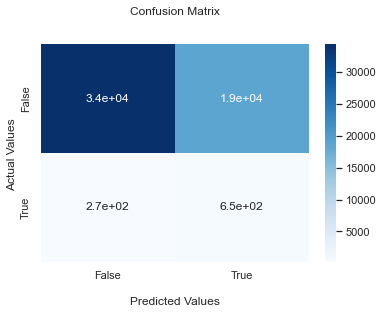

In [114]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [115]:
# Sensitivity is recall of positive class
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.65      0.78     52955
           1       0.03      0.71      0.06       920

    accuracy                           0.65     53875
   macro avg       0.51      0.68      0.42     53875
weighted avg       0.98      0.65      0.77     53875



# Random Forest with resampling

In [50]:
# Define the model you are interested in
RFmodel = RandomForestClassifier()

In [51]:
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('sampling', under), ('model', RFmodel)]
model = Pipeline([
        ('sampling', under),
        ('classification', RFmodel)
    ])

In [52]:
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for RF hyperparameters
# Number of trees in random forest
n_estimators = [10, 25, 50, 100, 150]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 50]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the grid
param_grid = {'classification__n_estimators': n_estimators,
               'classification__max_features': max_features,
               'classification__max_depth': max_depth,
               'classification__min_samples_split': min_samples_split,
               'classification__min_samples_leaf': min_samples_leaf,
               'classification__bootstrap': bootstrap}

In [53]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(model, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=Pipeline(steps=[('sampling',
                                         RandomUnderSampler(random_state=42,
                                                            sampling_strategy=0.25)),
                                        ('classification',
                                         RandomForestClassifier())]),
              refit=False, scoring='roc_auc',
              search_spaces={'classification__bootstrap': [True, False],
                             'classification__max_depth': [10, 50, None],
                             'classification__max_features': ['auto', 'sqrt'],
                             'classification__min_samples_leaf': [2, 4, 10],
                             'classification__min_samples_split': [5, 10],
                             'classification__n_estimators': [10, 25, 50, 100,
                                                              150]},
      

In [54]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('classification__bootstrap', True), ('classification__max_depth', None), ('classification__max_features', 'auto'), ('classification__min_samples_leaf', 10), ('classification__min_samples_split', 10), ('classification__n_estimators', 150)])
Best AUROC: 0.7433093874680914


Best parameter combo: OrderedDict([('classification__bootstrap', True), ('classification__max_depth', None), ('classification__max_features', 'auto'), ('classification__min_samples_leaf', 10), ('classification__min_samples_split', 10), ('classification__n_estimators', 150)])

In [55]:
# Test the model on standalone set
RFmodel = RandomForestClassifier(n_estimators = 150, max_features = 'auto', max_depth = None, min_samples_split = 10, min_samples_leaf = 10, bootstrap = True)

In [56]:
RFmodel.fit(X_res, np.ravel(y_res))

RandomForestClassifier(min_samples_leaf=10, min_samples_split=10,
                       n_estimators=150)

In [57]:
print('AUROC is:', metrics.roc_auc_score(y_test, RFmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, RFmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, RFmodel.predict_proba(X_test)[:,1]))
print('F1 score is:', metrics.f1_score(y_test, RFmodel.predict(X_test)))

AUROC is: 0.7420299741782399
Accuracy is: 0.9727703016241299
Average Precision is: 0.05020707260933724
F1 score is: 0.06619987269255251


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


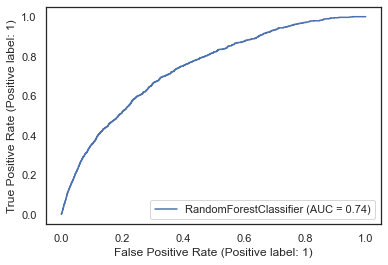

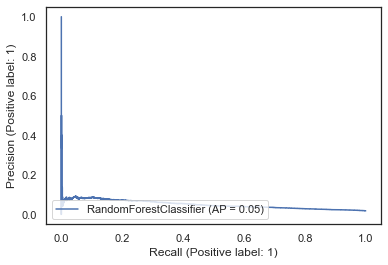

In [58]:
# Make metric plots
metrics.plot_roc_curve(RFmodel, X_test, y_test) 
metrics.plot_precision_recall_curve(RFmodel, X_test, y_test) 
plt.show()

# Logistic Regression with resampling

In [59]:
# Define the model you are interested in
LOGmodel = LogisticRegression(solver='liblinear', class_weight = 'balanced')

In [60]:
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('sampling', under), ('model', LOGmodel)]
model = Pipeline([
        ('sampling', under),
        ('classification', LOGmodel)
    ])

In [61]:
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for ElasticNet hyperparameters
# Regularisation constant
classifier__C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
# Which norm to use for regularisation
classifier__penalty = ['l1', 'l2']

# Create the grid
param_grid = {'classification__C': classifier__C,
               'classification__penalty': classifier__penalty}

In [62]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(model, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=Pipeline(steps=[('sampling',
                                         RandomUnderSampler(random_state=42,
                                                            sampling_strategy=0.25)),
                                        ('classification',
                                         LogisticRegression(class_weight='balanced',
                                                            solver='liblinear'))]),
              refit=False, scoring='roc_auc',
              search_spaces={'classification__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100],
                             'classification__penalty': ['l1', 'l2']},
              verbose=1)

In [63]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('classification__C', 1.0), ('classification__penalty', 'l1')])
Best AUROC: 0.7222334236086676


Best parameter combo: OrderedDict([('classification__C', 1.0), ('classification__penalty', 'l1')])


In [64]:
# Test the model on standalone set
LOGmodel = LogisticRegression(C=1, penalty='l1', solver='liblinear', class_weight = 'balanced')

In [65]:
LOGmodel.fit(X_res, np.ravel(y_res))

LogisticRegression(C=1, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [66]:
print('AUROC is:', metrics.roc_auc_score(y_test, LOGmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, LOGmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, LOGmodel.predict_proba(X_test)[:,1]))

AUROC is: 0.7170033005874553
Accuracy is: 0.6447146171693735
Average Precision is: 0.042263090605105975


# XGBoost on UK only

In [134]:
X_train = np.load('X_train_PE_no_lab_measurement_UK.npy')
X_test = np.load('X_test_PE_no_lab_measurement_UK.npy')
y_train = np.load('y_train_PE_no_lab_measurement_UK.npy')
y_test = np.load('y_test_PE_no_lab_measurement_UK.npy')

In [135]:
# Scale age
pre = preprocessing.StandardScaler()

age_column = X_train[:, 0]
age_column = np.atleast_2d(age_column).T

X_train[:, 0] = pre.fit_transform(age_column).ravel()

age_column = X_test[:, 0]
age_column = np.atleast_2d(age_column).T

X_test[:, 0] = pre.transform(age_column).ravel()

In [118]:
# Get the validation folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

In [71]:
# Tune the XGBoost model using Bayesian optimisation
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for XGBoost hyperparameters
# Depth of tree
max_depth = np.linspace(1, 12, 12, endpoint=True)
max_depth = [round(x) for x in max_depth]
# maximum features
n_estimators = list(range(50, 400, 50))
# Learning rate
lr = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7]
# Regularisation for imbalanced data
max_delta_step = [0, 1, 3, 5, 7, 10]

# Create the grid
param_grid = {'max_depth': max_depth,
               'n_estimators': n_estimators,
               'learning_rate': lr,
               'max_delta_step': max_delta_step}

In [72]:
# Define the model you are interested in
XGBOOSTmodel = XGBClassifier(use_label_encoder=False)

In [73]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(XGBOOSTmodel, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[10:44:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:44:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[10:51:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:51:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:51:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[10:57:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:58:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:58:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:02:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:02:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:02:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:09:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:09:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:09:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:18:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:22:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:22:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:22:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:29:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:29:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:29:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:36:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:42:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:43:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:43:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      enable_categorical=False, gamma=None,
                                      gpu_id=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_delta_step=None,
                                      max_depth=None, min_...
                                      reg_lambda=None, scale_pos_weight=None,
                                      subsample=None, tree_method=None,
                                      use_label_encoder=False,
                                      validate_parameters=None,
                                   

In [74]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('learning_rate', 0.1), ('max_delta_step', 3), ('max_depth', 3), ('n_estimators', 250)])
Best AUROC: 0.727134837761259


Best parameter combo: OrderedDict([('learning_rate', 0.1), ('max_delta_step', 3), ('max_depth', 3), ('n_estimators', 250)])

In [136]:
# Test the model on standalone set of UK
XGBOOSTmodel = XGBClassifier(max_depth = 3, n_estimators = 250,learning_rate = 0.1, max_delta_step = 3, use_label_encoder=False)

In [137]:
XGBOOSTmodel.fit(X_train, np.ravel(y_train))

[12:58:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=3,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [77]:
print('AUROC is:', metrics.roc_auc_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, XGBOOSTmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))

AUROC is: 0.7202698041891571
Accuracy is: 0.9841638305824956
Average Precision is: 0.03786678601930647


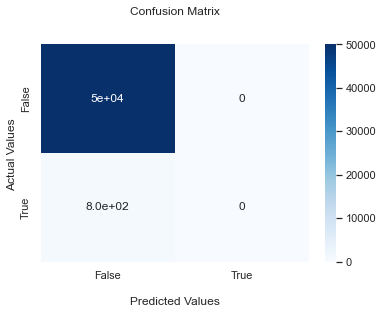

In [78]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, XGBOOSTmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [121]:
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = XGBOOSTmodel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.015, AUROC-Score=0.69277


In [122]:
y_pred = (XGBOOSTmodel.predict_proba(X_test)[:,1] >= 0.015).astype(int) # set threshold as 0.3

print('AUROC is:', metrics.roc_auc_score(y_test, y_pred))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred))

AUROC is: 0.6579380267547068
Accuracy is: 0.6250270493577007
Average Precision is: 0.0247755963278702


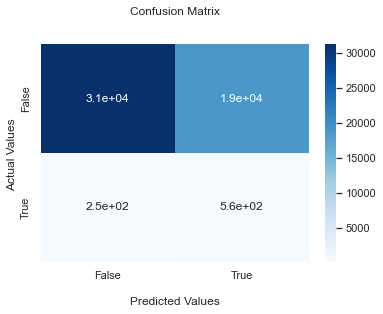

In [123]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [124]:
# Sensitivity is recall of positive class
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.62      0.77     50028
           1       0.03      0.69      0.06       805

    accuracy                           0.63     50833
   macro avg       0.51      0.66      0.41     50833
weighted avg       0.98      0.63      0.75     50833



In [138]:
# Test on Spain data
X_train_Spain = np.load('X_train_PE_no_lab_measurement_Spain.npy')
X_test_Spain = np.load('X_test_PE_no_lab_measurement_Spain.npy')
y_train_Spain = np.load('y_train_PE_no_lab_measurement_Spain.npy')
y_test_Spain = np.load('y_test_PE_no_lab_measurement_Spain.npy')

X_test = np.concatenate((X_train_Spain, X_test_Spain), axis=0)
y_test = np.concatenate((y_train_Spain, y_test_Spain), axis=0)

In [139]:
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = XGBOOSTmodel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.015, AUROC-Score=0.69277


In [140]:
y_pred = (XGBOOSTmodel.predict_proba(X_test)[:,1] >= 0.015).astype(int) # set threshold as 0.3

print('AUROC is:', metrics.roc_auc_score(y_test, y_pred))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred))

AUROC is: 0.5877965342324282
Accuracy is: 0.8550762756443977
Average Precision is: 0.05261015399768837


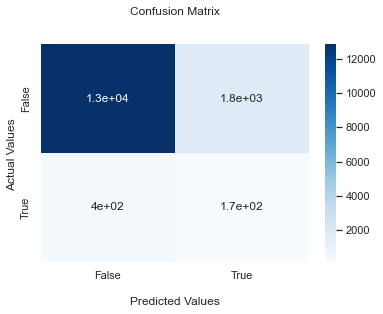

In [141]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [142]:
# Sensitivity is recall of positive class
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     14632
           1       0.09      0.30      0.14       576

    accuracy                           0.86     15208
   macro avg       0.53      0.59      0.53     15208
weighted avg       0.94      0.86      0.89     15208



# XGBoost on Spain only

In [12]:
X_train = np.load('X_train_PE_no_lab_measurement_Spain.npy')
X_test = np.load('X_test_PE_no_lab_measurement_Spain.npy')
y_train = np.load('y_train_PE_no_lab_measurement_Spain.npy')
y_test = np.load('y_test_PE_no_lab_measurement_Spain.npy')

In [13]:
# Scale age
pre = preprocessing.StandardScaler()

age_column = X_train[:, 0]
age_column = np.atleast_2d(age_column).T

X_train[:, 0] = pre.fit_transform(age_column).ravel()

age_column = X_test[:, 0]
age_column = np.atleast_2d(age_column).T

X_test[:, 0] = pre.transform(age_column).ravel()

In [14]:
# Get the validation folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

In [83]:
# Tune the XGBoost model using Bayesian optimisation
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for XGBoost hyperparameters
# Depth of tree
max_depth = np.linspace(1, 12, 12, endpoint=True)
max_depth = [round(x) for x in max_depth]
# maximum features
n_estimators = list(range(50, 400, 50))
# Learning rate
lr = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7]
# Regularisation for imbalanced data
max_delta_step = [0, 1, 3, 5, 7, 10]

# Create the grid
param_grid = {'max_depth': max_depth,
               'n_estimators': n_estimators,
               'learning_rate': lr,
               'max_delta_step': max_delta_step}

In [84]:
# Define the model you are interested in
XGBOOSTmodel = XGBClassifier(use_label_encoder=False)

In [85]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(XGBOOSTmodel, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:54:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:54:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:54:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:55:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:55:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:55:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:55:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:55:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:55:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:55:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:55:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:55:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:56:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:56:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:56:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:56:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:56:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:56:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:57:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:58:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:58:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:58:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:59:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:59:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:59:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:59:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:59:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:59:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      enable_categorical=False, gamma=None,
                                      gpu_id=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_delta_step=None,
                                      max_depth=None, min_...
                                      reg_lambda=None, scale_pos_weight=None,
                                      subsample=None, tree_method=None,
                                      use_label_encoder=False,
                                      validate_parameters=None,
                                   

In [86]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('learning_rate', 0.1), ('max_delta_step', 7), ('max_depth', 2), ('n_estimators', 150)])
Best AUROC: 0.7688901213983547


Best parameter combo: OrderedDict([('learning_rate', 0.1), ('max_delta_step', 7), ('max_depth', 2), ('n_estimators', 150)])

In [15]:
# Test the model on standalone set of Spain
XGBOOSTmodel = XGBClassifier(max_depth = 2, n_estimators = 150,learning_rate = 0.1, max_delta_step = 7, use_label_encoder=False)

In [16]:
XGBOOSTmodel.fit(X_train, np.ravel(y_train))

[11:32:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=7,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [24]:
y_pred = XGBOOSTmodel.predict(X_test)
print('AUROC is:', metrics.roc_auc_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, XGBOOSTmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))

AUROC is: 0.789826354332229
Accuracy is: 0.9621959237343852
Average Precision is: 0.08998415031567751


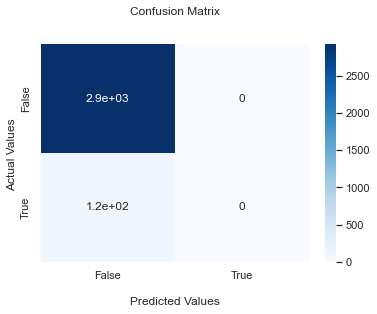

In [18]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, XGBOOSTmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [25]:
# Sensitivity is recall of positive class
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2927
           1       0.00      0.00      0.00       115

    accuracy                           0.96      3042
   macro avg       0.48      0.50      0.49      3042
weighted avg       0.93      0.96      0.94      3042



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [130]:
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = XGBOOSTmodel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.044, AUROC-Score=0.76697


In [131]:
y_pred = (XGBOOSTmodel.predict_proba(X_test)[:,1] >= 0.044).astype(int) # set threshold as 0.3

print('AUROC is:', metrics.roc_auc_score(y_test, y_pred))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred))

AUROC is: 0.797546085174017
Accuracy is: 0.6666666666666666
Average Precision is: 0.09326621809516962


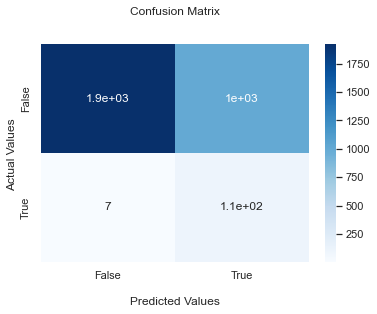

In [132]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [133]:
# Sensitivity is recall of positive class
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.66      0.79      2927
           1       0.10      0.94      0.18       115

    accuracy                           0.67      3042
   macro avg       0.55      0.80      0.48      3042
weighted avg       0.96      0.67      0.77      3042

